# Caderno 8 - Calcula métricas considerando os resultados de pesquisa em um BM25 com expansão de documentos usando a reescrita de enunciados pelo GPT e pelo Llama

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO_LLAMA = False
REINDEXAR_ENUNCIADO_EXCERTO_GPT = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/8_metricas_bm25_com_gpt_llama/'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_gpt.pickle'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_llama.pickle'

# 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

Carrega a expansão das queries gerada no caderno anterior:

In [3]:
import pickle

PASTA_CADERNO_REESCRITA_GPT_LLAMA = f'{PASTA_DADOS}outputs/7_gpt_llama/'
NOME_ARQUIVO_RESULTADO_LLAMA = f'{PASTA_CADERNO_REESCRITA_GPT_LLAMA}enunciados_llama.pickle'
NOME_ARQUIVO_RESULTADO_GPT = f'{PASTA_CADERNO_REESCRITA_GPT_LLAMA}enunciados_gpt.pickle'

with open(NOME_ARQUIVO_RESULTADO_LLAMA, 'rb') as f:
    enunciado_llama_por_doc = pickle.load(f)
with open(NOME_ARQUIVO_RESULTADO_GPT, 'rb') as f:
    enunciado_gpt_por_doc = pickle.load(f)

Insere a reescrita no dataframe de documentos.

In [4]:
docs['ENUNCIADO_LLAMA'] = docs['KEY'].map(lambda key: enunciado_llama_por_doc[key])
docs['ENUNCIADO_GPT'] = docs['KEY'].map(lambda key: enunciado_gpt_por_doc[key])

# 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO e as queries expandidas

In [5]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [6]:
import os

# Vamos criar um índice invertido e indexar o enunciado, excerto e o enunciado gerado com o Llama
iidx_expansao_llama = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_ENUNCIADO_EXCERTO_LLAMA or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA):
    # Se for indexar a primeira vez:
    # Demora cerca de 40 minutos para indexar
    iidx_expansao_llama.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['ENUNCIADO_LLAMA']))
    iidx_expansao_llama.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA)
else:
    # Se quiser recuperar de um arquivo:
    iidx_expansao_llama.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_LLAMA)

In [7]:
# Vamos criar um índice invertido e indexar o enunciado, excerto e o enunciado gerado com o GPT
iidx_expansao_gpt = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_ENUNCIADO_EXCERTO_GPT or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT):
    # Se for indexar a primeira vez:
    # Demora cerca de 40 minutos para indexar
    iidx_expansao_gpt.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['ENUNCIADO_GPT']))
    iidx_expansao_gpt.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT)
else:
    # Se quiser recuperar de um arquivo:
    iidx_expansao_gpt.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT)

In [8]:
print(iidx_expansao_llama.get_tamanho_medio_docs())
print(iidx_expansao_gpt.get_tamanho_medio_docs())

511.41782486756
499.63589903396695


In [9]:
buscador_llama = BM25(iidx_expansao_llama, k1=0.82, b=0.68, bias_idf=1)
buscador_gpt = BM25(iidx_expansao_gpt, k1=0.82, b=0.68, bias_idf=1)

# 3. Faz as pesquisas e salva os resultados

In [10]:
col_resultado_query_key_llama=[]
col_resultado_doc_key_llama=[]
col_resultado_rank_llama=[]

col_resultado_query_key_gpt=[]
col_resultado_doc_key_gpt=[]
col_resultado_rank_gpt=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    
    resultados_llama = buscador_llama.pesquisar(query_text)
    resultados_gpt = buscador_gpt.pesquisar(query_text)

    # Llama
    primeiros_50_docs_llama = [tupla_key_score[0] for tupla_key_score in resultados_llama[:50]]
    queries_keys_llama = [query_key] * len(primeiros_50_docs_llama)
    ranking_llama = list(range(1, len(primeiros_50_docs_llama)+1))

    col_resultado_query_key_llama.extend(queries_keys_llama)
    col_resultado_doc_key_llama.extend(primeiros_50_docs_llama)
    col_resultado_rank_llama.extend(ranking_llama)

    # GPT
    primeiros_50_docs_gpt = [tupla_key_score[0] for tupla_key_score in resultados_gpt[:50]]
    queries_keys_gpt = [query_key] * len(primeiros_50_docs_gpt)
    ranking_gpt = list(range(1, len(primeiros_50_docs_gpt)+1))

    col_resultado_query_key_gpt.extend(queries_keys_gpt)
    col_resultado_doc_key_gpt.extend(primeiros_50_docs_gpt)
    col_resultado_rank_gpt.extend(ranking_gpt)


df_resultados_llama = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key_llama,
    "DOC_KEY": col_resultado_doc_key_llama,
    "RANK": col_resultado_rank_llama,
})

df_resultados_gpt = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key_gpt,
    "DOC_KEY": col_resultado_doc_key_gpt,
    "RANK": col_resultado_rank_gpt,
})

In [11]:
from metricas import metricas

df_metricas_llama = metricas(df_resultados_llama, qrels, aproximacao_trec_eval=True)
df_metricas_gpt = metricas(df_resultados_gpt, qrels, aproximacao_trec_eval=True)

## 3.1 Resultados Llama

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.260000,0.258000,0.220000,0.125600,0.104738,0.212170,0.364458,0.517955,0.452667,0.471079,0.479581,0.481067,0.263094,0.279743,0.355111,0.428228
std,14.57738,0.256348,0.190692,0.125357,0.058976,0.097805,0.162760,0.223648,0.272956,0.411999,0.394111,0.384328,0.382478,0.264027,0.228987,0.230072,0.233241
min,1.00000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.034066
25%,13.25000,0.000000,0.100000,0.150000,0.080000,0.000000,0.083333,0.207692,0.307692,0.000000,0.166667,0.166667,0.166667,0.000000,0.116018,0.179447,0.222781
50%,25.50000,0.200000,0.200000,0.200000,0.120000,0.083333,0.190909,0.360390,0.483333,0.333333,0.333333,0.333333,0.333333,0.173458,0.240578,0.349336,0.439095
75%,37.75000,0.400000,0.400000,0.300000,0.180000,0.166667,0.342857,0.519231,0.758741,1.000000,1.000000,1.000000,1.000000,0.394782,0.416558,0.500478,0.598982
max,50.00000,1.000000,0.700000,0.500000,0.200000,0.384615,0.571429,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.838362,0.837535,0.837535


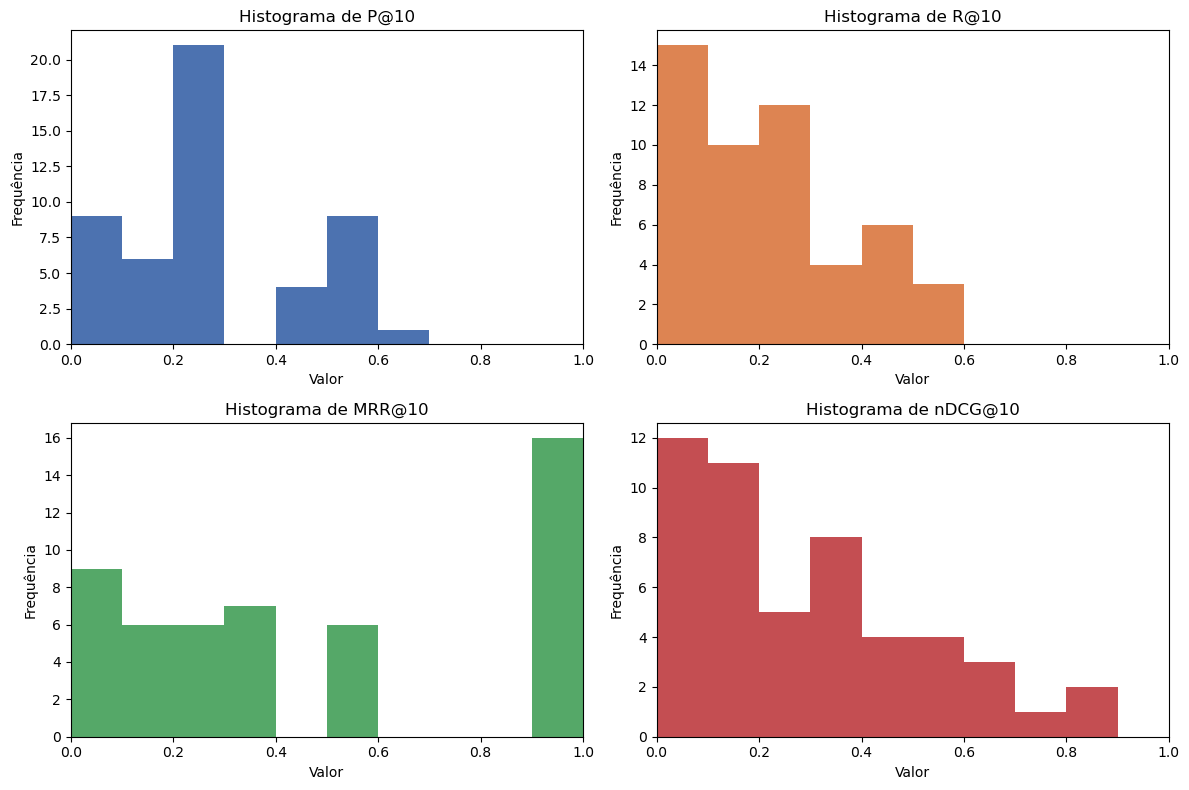

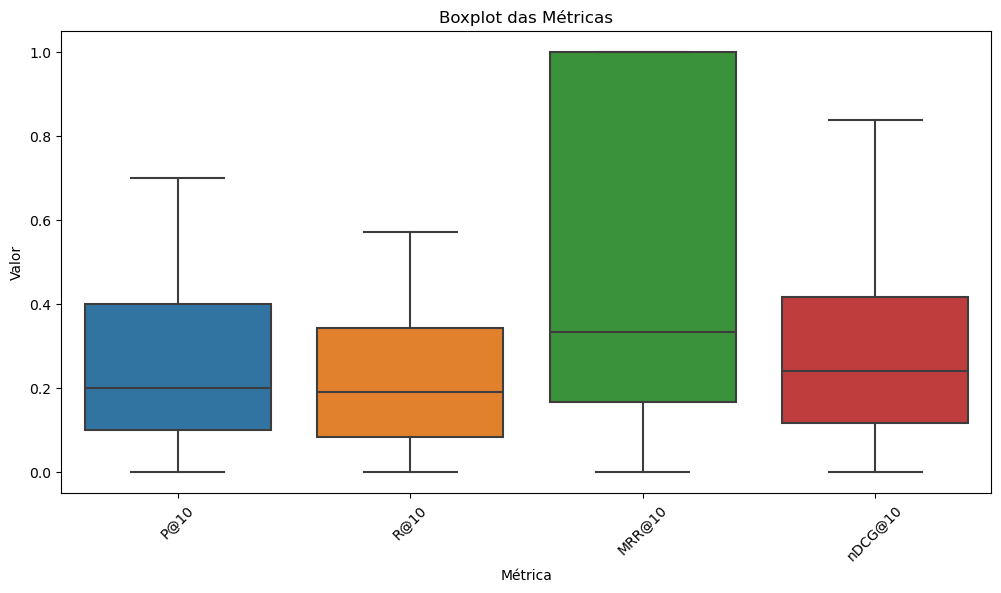

In [12]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries, Llama:
display(df_metricas_llama[0:50].describe())
histograma_metricas(df_metricas_llama[0:50])
boxplot_metricas(df_metricas_llama[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.528000,0.400000,0.273000,0.142400,0.221659,0.335992,0.458243,0.591768,0.900000,0.905556,0.905556,0.905556,0.604789,0.539215,0.576866,0.638872
std,14.57738,0.270329,0.196915,0.127859,0.049757,0.118089,0.179240,0.230997,0.222397,0.262445,0.243846,0.243846,0.243846,0.233839,0.185519,0.196138,0.173940
min,51.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.106473,0.098246,0.127326
25%,63.25000,0.400000,0.300000,0.150000,0.105000,0.145604,0.230769,0.275974,0.436813,1.000000,1.000000,1.000000,1.000000,0.475705,0.453517,0.450909,0.537092
50%,75.50000,0.500000,0.400000,0.275000,0.160000,0.218254,0.296703,0.458042,0.615385,1.000000,1.000000,1.000000,1.000000,0.637550,0.538858,0.593374,0.657383
75%,87.75000,0.800000,0.575000,0.350000,0.180000,0.326923,0.448052,0.583333,0.750000,1.000000,1.000000,1.000000,1.000000,0.749826,0.685360,0.680127,0.742286
max,100.00000,1.000000,0.800000,0.500000,0.200000,0.454545,0.727273,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.906178,0.925634,0.958828


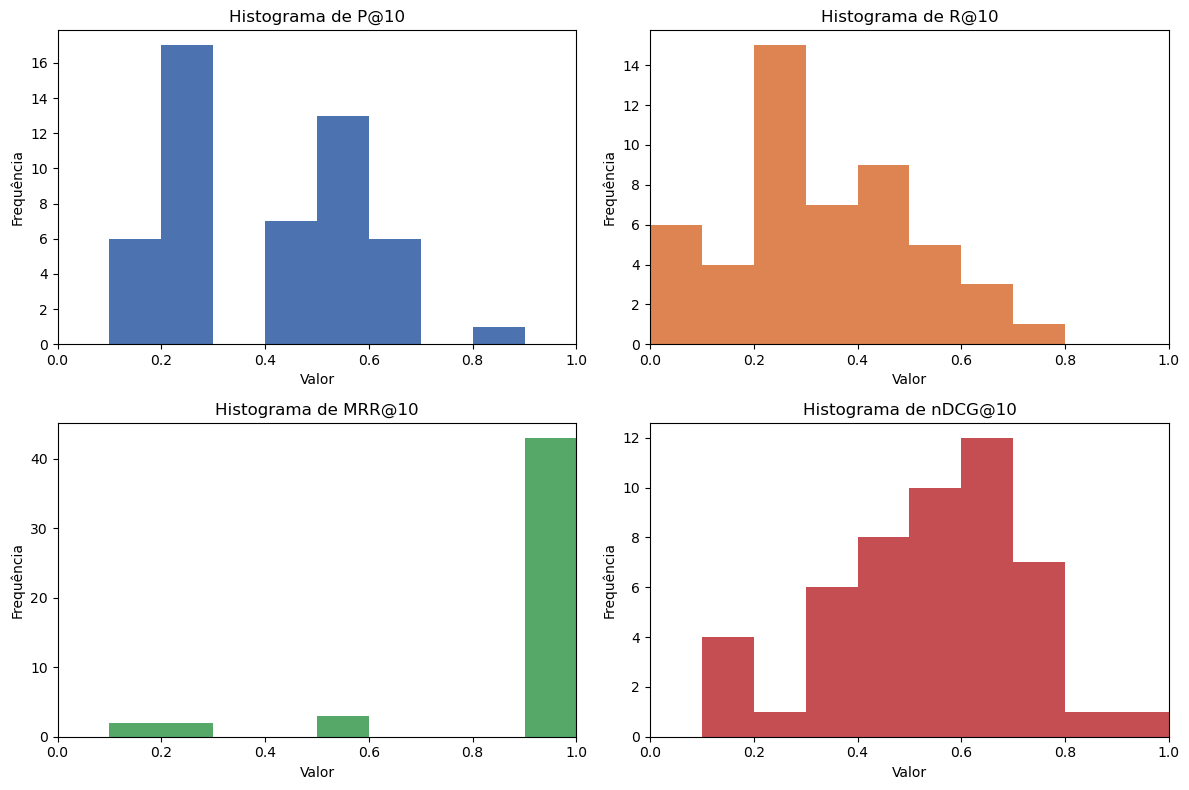

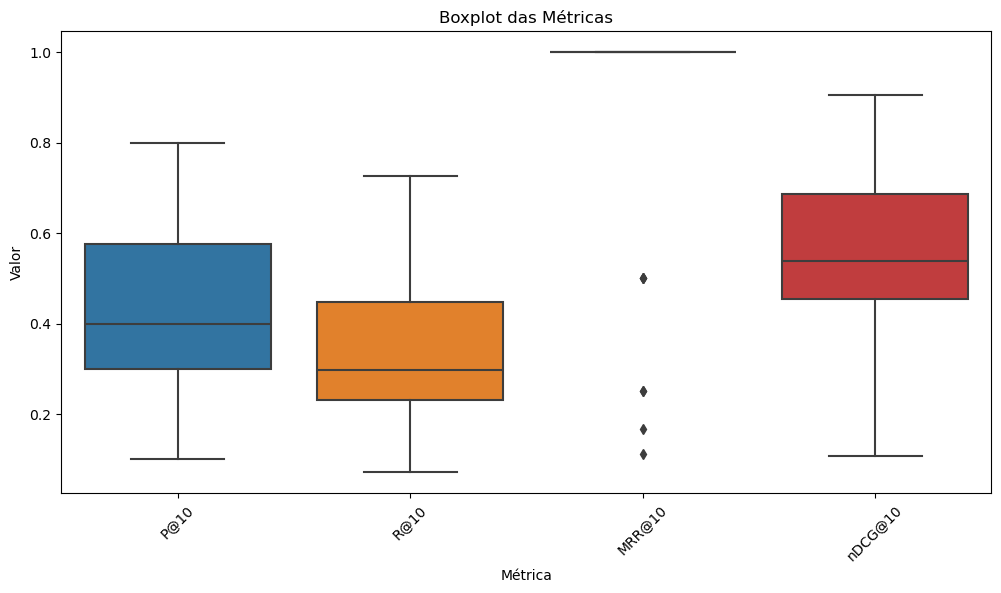

In [13]:
# Resultados para o segundo grupo de queries, Llama:
display(df_metricas_llama[50:100].describe())
histograma_metricas(df_metricas_llama[50:100])
boxplot_metricas(df_metricas_llama[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.544000,0.392000,0.276000,0.13760,0.243707,0.347570,0.488984,0.604744,0.935000,0.935000,0.935000,0.935000,0.631313,0.546519,0.604444,0.651925
std,14.57738,0.232256,0.183881,0.123817,0.05153,0.112113,0.160981,0.222066,0.223884,0.180772,0.180772,0.180772,0.180772,0.194992,0.171690,0.175840,0.165129
min,101.00000,0.200000,0.100000,0.050000,0.02000,0.066667,0.066667,0.100000,0.100000,0.250000,0.250000,0.250000,0.250000,0.097379,0.138658,0.234829,0.266717
25%,113.25000,0.400000,0.300000,0.200000,0.10000,0.166667,0.235577,0.363636,0.454545,1.000000,1.000000,1.000000,1.000000,0.494669,0.442750,0.472981,0.528646
50%,125.50000,0.600000,0.400000,0.250000,0.15000,0.250000,0.333333,0.500000,0.625874,1.000000,1.000000,1.000000,1.000000,0.615480,0.567130,0.636755,0.692618
75%,137.75000,0.750000,0.500000,0.350000,0.18000,0.333333,0.461538,0.611538,0.750000,1.000000,1.000000,1.000000,1.000000,0.778675,0.641206,0.748044,0.777036
max,150.00000,1.000000,0.800000,0.500000,0.22000,0.500000,0.727273,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.872048,0.936855,0.936855


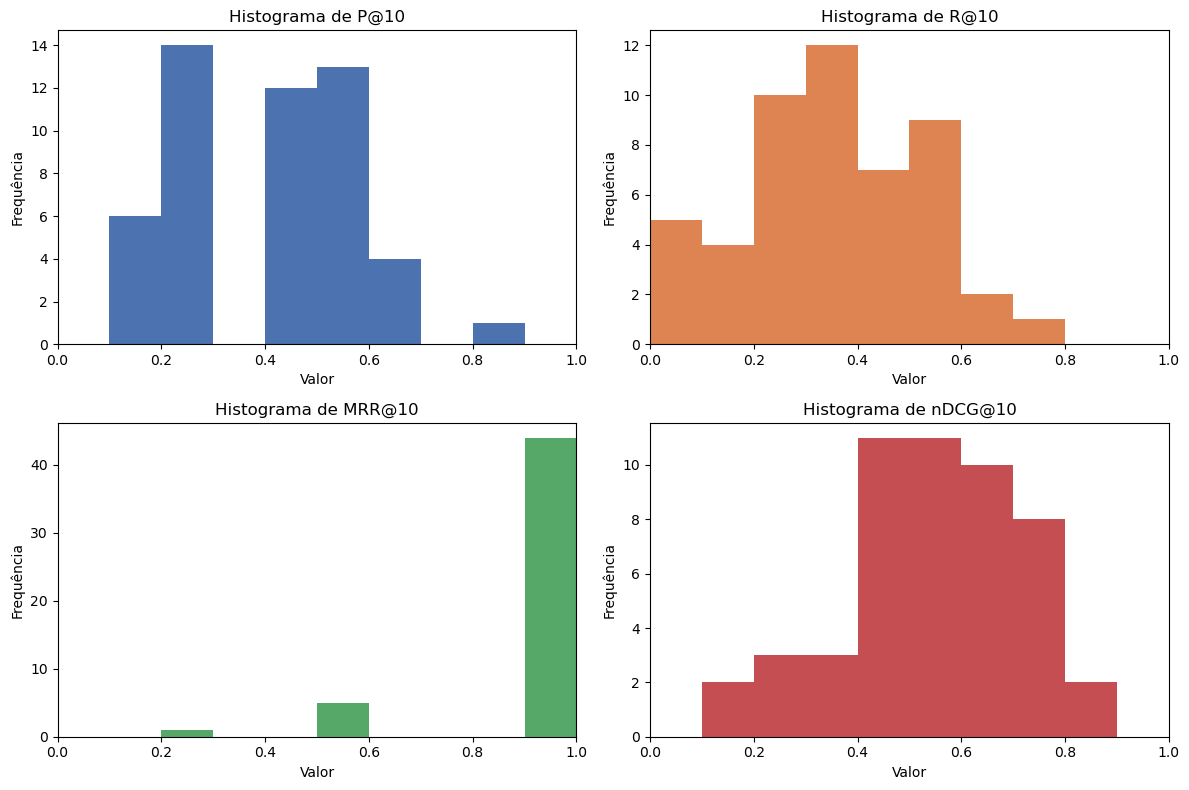

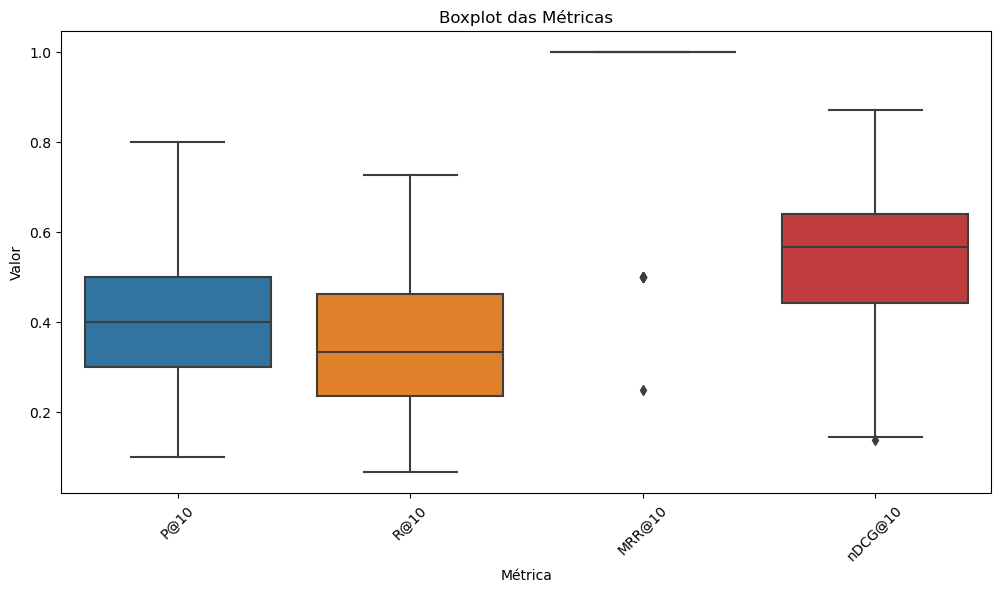

In [14]:
# Resultados para o terceiro grupo de queries, Llama:
display(df_metricas_llama[100:150].describe())
histograma_metricas(df_metricas_llama[100:150])
boxplot_metricas(df_metricas_llama[100:150])

## 3.2 Resultados GPT

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.26000,0.262000,0.217000,0.124400,0.104336,0.215303,0.359729,0.511235,0.486000,0.507603,0.513918,0.515383,0.268485,0.283789,0.356660,0.428959
std,14.57738,0.24661,0.179444,0.131944,0.057894,0.094075,0.156525,0.236221,0.263433,0.419958,0.396891,0.389180,0.387275,0.255223,0.215910,0.229422,0.224103
min,1.00000,0.00000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.038472
25%,13.25000,0.00000,0.100000,0.100000,0.080000,0.000000,0.076923,0.157051,0.307692,0.000000,0.166667,0.166667,0.166667,0.000000,0.093021,0.191565,0.230003
50%,25.50000,0.20000,0.250000,0.200000,0.120000,0.083333,0.207143,0.345238,0.464103,0.333333,0.333333,0.333333,0.333333,0.231560,0.266371,0.336099,0.426448
75%,37.75000,0.40000,0.400000,0.300000,0.180000,0.153846,0.307692,0.461538,0.755495,1.000000,1.000000,1.000000,1.000000,0.366572,0.421278,0.550181,0.607499
max,50.00000,1.00000,0.700000,0.500000,0.200000,0.384615,0.571429,0.818182,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,0.842749,0.841333,0.841333


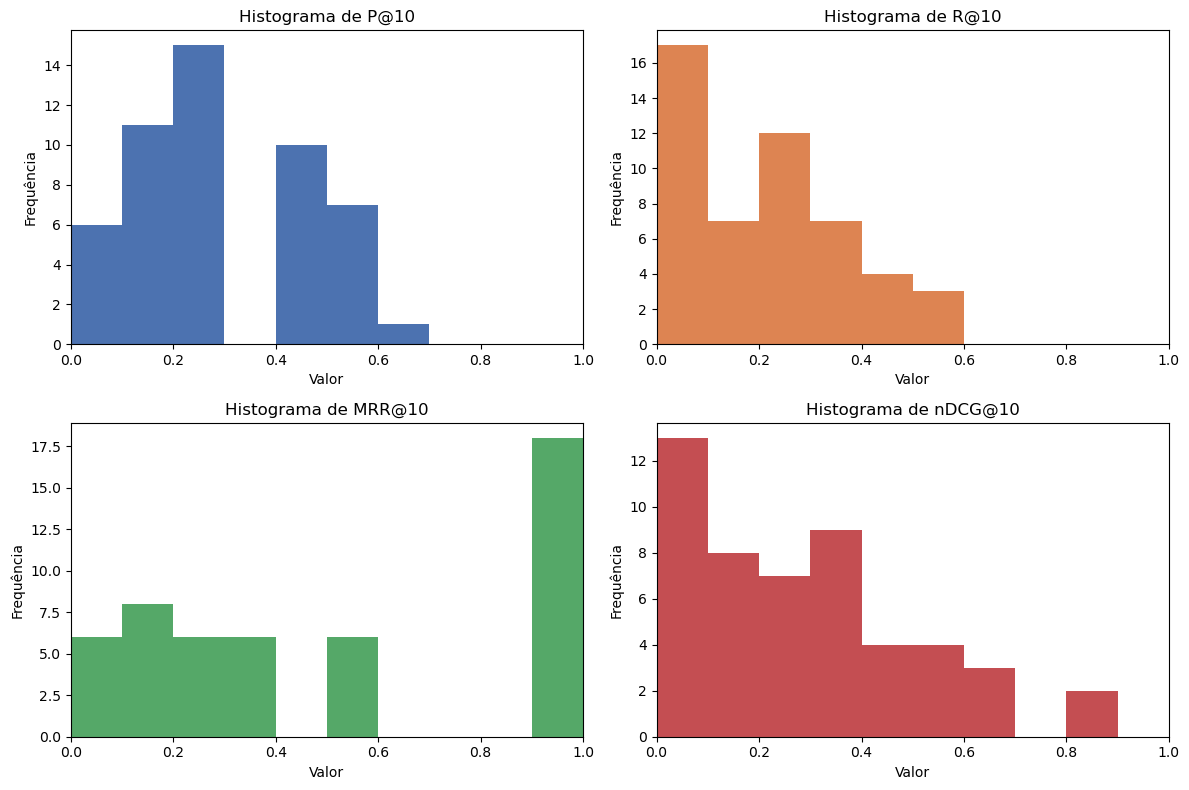

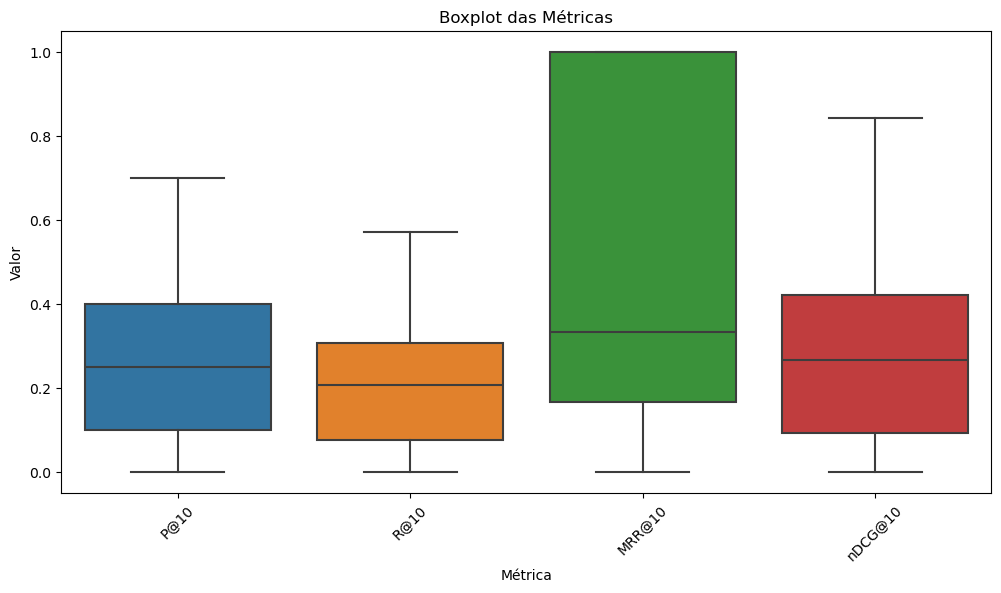

In [15]:
# Resultados para o primeiro grupo de queries, GPT:
display(df_metricas_gpt[0:50].describe())
histograma_metricas(df_metricas_gpt[0:50])
boxplot_metricas(df_metricas_gpt[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.536000,0.38800,0.268000,0.142400,0.224834,0.326820,0.448056,0.593505,0.906667,0.915000,0.915000,0.915000,0.612954,0.535770,0.577851,0.640655
std,14.57738,0.278304,0.20468,0.127679,0.049921,0.120789,0.186873,0.228643,0.224496,0.267600,0.239425,0.239425,0.239425,0.240220,0.188935,0.195977,0.180810
min,51.00000,0.000000,0.10000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.125000,0.125000,0.125000,0.000000,0.054163,0.120544,0.150664
25%,63.25000,0.400000,0.20000,0.150000,0.105000,0.145604,0.180556,0.255682,0.436813,1.000000,1.000000,1.000000,1.000000,0.477643,0.406473,0.459192,0.537764
50%,75.50000,0.600000,0.40000,0.250000,0.160000,0.230769,0.307692,0.435606,0.615385,1.000000,1.000000,1.000000,1.000000,0.640281,0.558519,0.587796,0.666364
75%,87.75000,0.800000,0.57500,0.350000,0.180000,0.326923,0.448052,0.595833,0.750000,1.000000,1.000000,1.000000,1.000000,0.754991,0.681279,0.717329,0.753321
max,100.00000,1.000000,0.80000,0.500000,0.200000,0.454545,0.800000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.836926,0.912494,0.945171


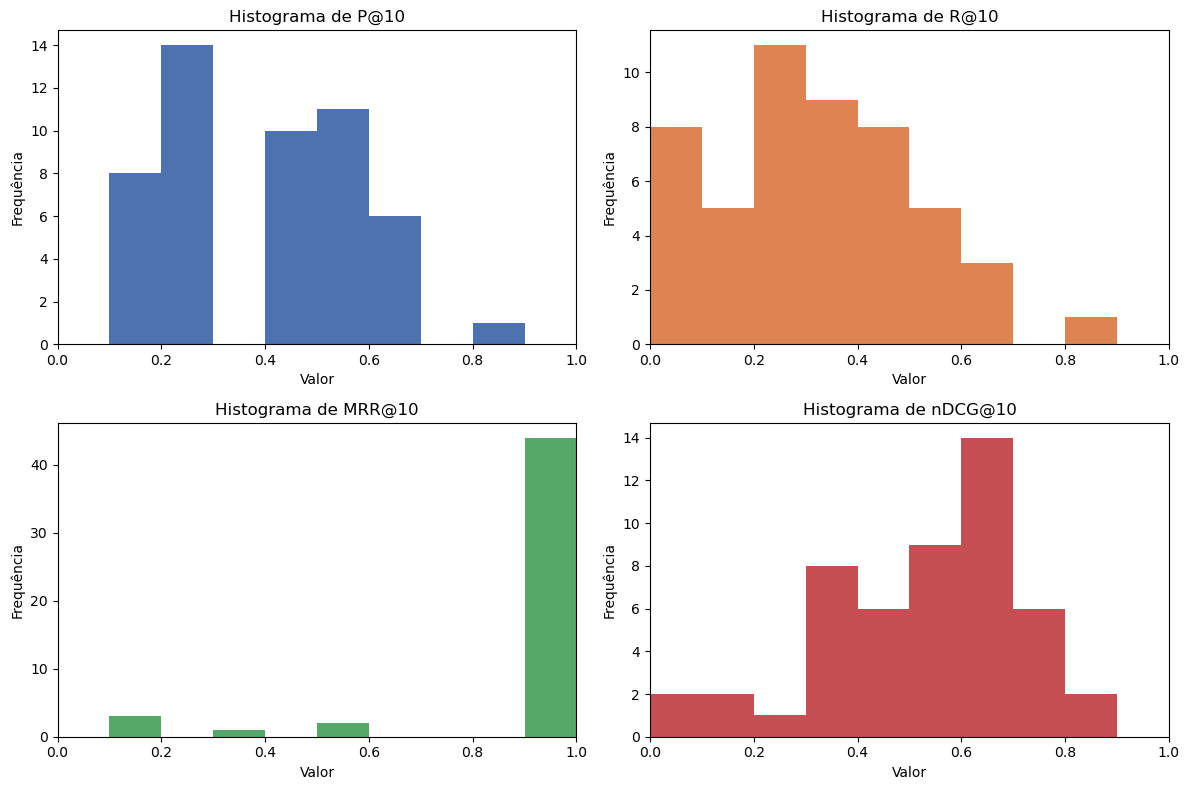

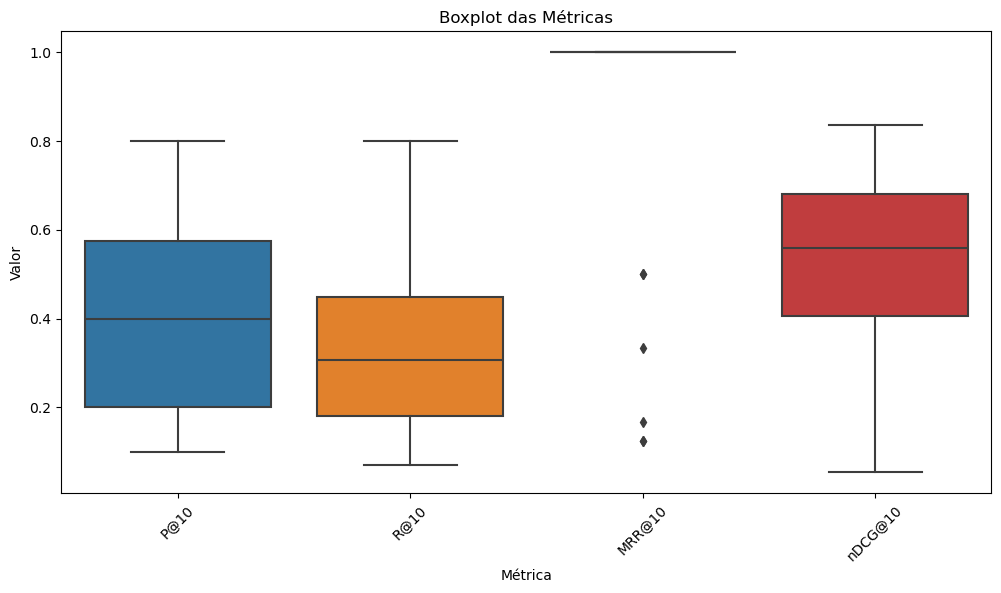

In [16]:
# Resultados para o segundo grupo de queries, GPT:
display(df_metricas_gpt[50:100].describe())
histograma_metricas(df_metricas_gpt[50:100])
boxplot_metricas(df_metricas_gpt[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.548000,0.396000,0.266000,0.137600,0.245121,0.350609,0.470093,0.605208,0.950000,0.952500,0.952500,0.952500,0.636556,0.549484,0.595488,0.652550
std,14.57738,0.258125,0.197907,0.128349,0.050892,0.123078,0.171498,0.225203,0.221106,0.182108,0.169201,0.169201,0.169201,0.208658,0.181372,0.188052,0.165959
min,101.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.066667,0.066667,0.100000,0.000000,0.125000,0.125000,0.125000,0.000000,0.074372,0.145975,0.273274
25%,113.25000,0.400000,0.200000,0.150000,0.100000,0.166667,0.207692,0.279545,0.456294,1.000000,1.000000,1.000000,1.000000,0.494669,0.436681,0.452464,0.545009
50%,125.50000,0.600000,0.400000,0.250000,0.140000,0.230769,0.348485,0.461538,0.625874,1.000000,1.000000,1.000000,1.000000,0.654809,0.578551,0.617628,0.682080
75%,137.75000,0.800000,0.500000,0.350000,0.180000,0.333333,0.454545,0.595833,0.737500,1.000000,1.000000,1.000000,1.000000,0.783929,0.681594,0.732525,0.772815
max,150.00000,1.000000,0.800000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.884592,0.947389,0.947389


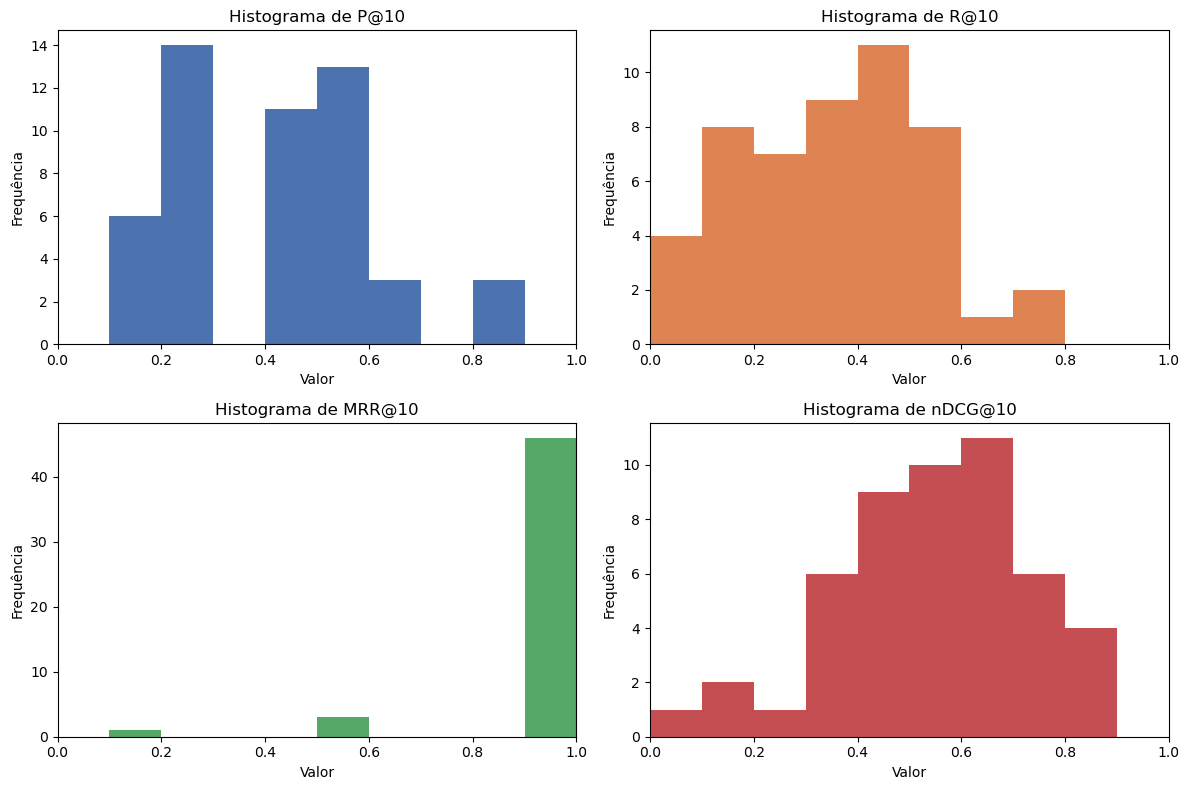

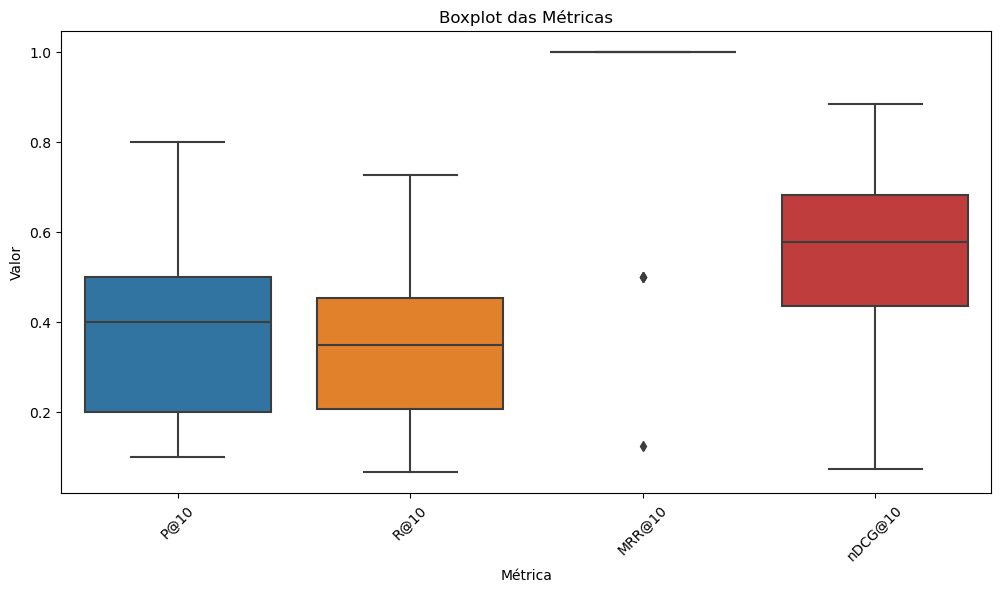

In [17]:
# Resultados para o terceiro grupo de queries, GPT:
display(df_metricas_gpt[100:150].describe())
histograma_metricas(df_metricas_gpt[100:150])
boxplot_metricas(df_metricas_gpt[100:150])